In [29]:
from jetutils.jet_finding import JetFindingExperiment
from jetutils.definitions import DATADIR, compute, xarray_to_polars, get_region, labels_to_mask
from jetutils.plots import Clusterplot, COLORS
from jetutils.data import DataHandler, open_dataset, compute_anomalies_pl, coarsen_da, extract, smooth
from jetutils.clustering import Experiment
from jetutils.anyspell import mask_from_spells_pl, get_persistent_spell_times_from_som
import colormaps

import numpy as np
import polars as pl
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from pathlib import Path
import datetime

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
basepath = Path("/storage/workspaces/giub_meteo_impacts/ci01/CESM2/high_wind/historical")
ds = open_dataset(basepath.joinpath("ds.zarr"))
ds["time"] = ds.indexes["time"].to_datetimeindex(time_unit="ns")
da_s = compute(ds["s"], progress_flag=True)
dh = DataHandler.from_basepath_and_da(basepath.joinpath("results"), ds["s"])
exp = Experiment(dh)

Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.


In [ ]:
def extract_dynamical_seasons(labels: pl.DataFrame, len_spring: int = 20):    
    summer_cluster = labels.filter(pl.col("time").dt.month() == 7)["labels"].mode().item()
    seasons = labels.group_by(
        pl.col("time").dt.year().alias("year"), pl.col("member")
    ).agg(
        pl.col("time").get((pl.col("labels") == summer_cluster).arg_true().first()).alias("start"),
        pl.col("time").get((pl.col("labels") == summer_cluster).arg_true().last()).alias("end")
    ).with_columns(
        spring=pl.datetime_ranges(pl.col("start") - datetime.timedelta(days=len_spring), pl.col("start"), "1d"),
        summer=pl.datetime_ranges(pl.col("start"), pl.col("end"), "1d"),
        autumn=pl.datetime_ranges(pl.col("end"), pl.col("end") + datetime.timedelta(days=len_spring), "1d"),
    ).drop("year", "start", "end")
    return [seasons[["member", season]].explode(season).sort("member", season) for season in ["spring", "summer", "autumn"]]

In [4]:
centers_kmeans, labels_kmeans = exp.do_kmeans(7, 200)
spring, summer, autumn = extract_dynamical_seasons(xarray_to_polars(labels_kmeans), 20)
members = summer["member"].unique().sort().to_numpy()
index = summer.to_pandas().set_index(["member", "summer"]).index
summer_da = dh.da.stack({"megatime": ["member", "time"]}).sel(megatime=index).transpose("megatime", ...)
dh_summer = DataHandler.from_basepath_and_da(exp.path.parent, summer_da, save_da=False)
exp_summer = Experiment(dh_summer)
net_summer, centers_summer, labels_summer = exp_summer.som_cluster(4, 4, 200, sigma=1.5, sigmaN=1e-5, train_kwargs=dict(num_epochs=20), init="pca")
mask = labels_to_mask(labels_summer, as_da=True)

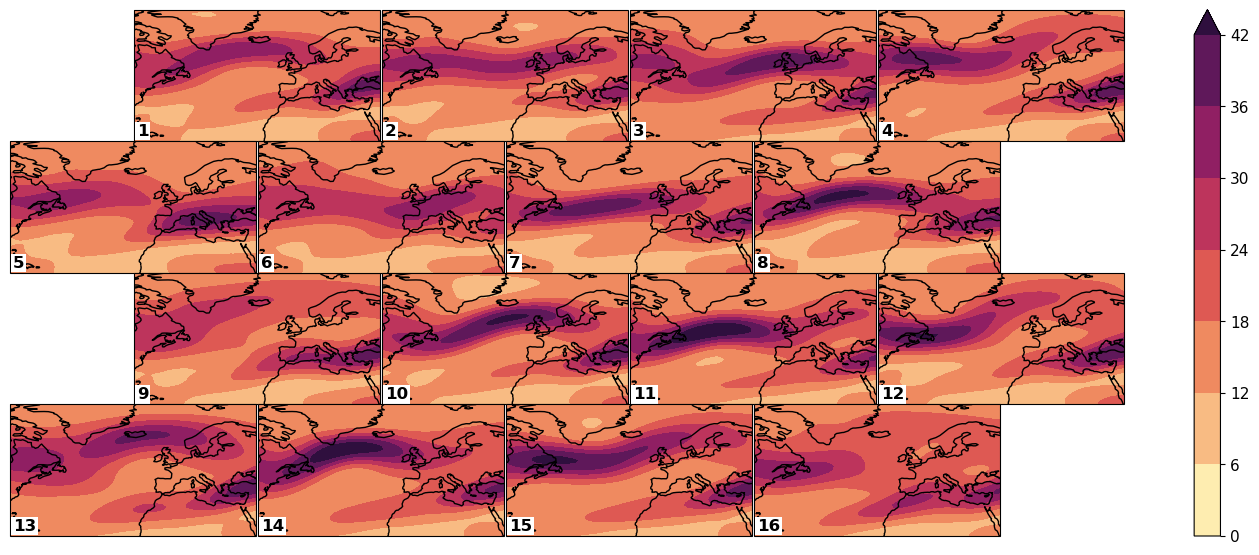

In [5]:
clu = Clusterplot(4, 4, get_region(dh.da), honeycomb=True, numbering=True)
_ = clu.add_contourf(centers_summer, cmap=colormaps.matter, levels=7)

In [6]:
from sklearn.metrics import pairwise_distances
dists = pairwise_distances(net_summer.weights)
sigma = np.quantile(dists[dists > 0].flatten(), 0.1)
spells = get_persistent_spell_times_from_som(labels_summer, dists, sigma, 12, nt_before=32, nojune=False, daily=False)

(<Figure size 500x400 with 2 Axes>, <Axes: >)

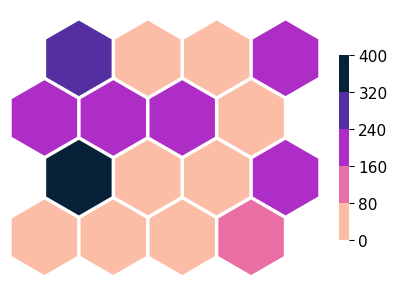

In [7]:
spells_per_cluster = spells.filter(pl.col("relative_index") == 0).group_by("value").len()
spells_per_cluster = pl.Series("value", np.arange(net_summer.n_nodes)).to_frame().join(spells_per_cluster, how="left", on="value").fill_null(0)
cmap = colormaps.bubblegum_r
net_summer.plot_on_map(spells_per_cluster["len"].to_numpy(), cmap=cmap, discretify=True, cbar_kwargs={"shrink": 0.6})

(<Figure size 500x400 with 2 Axes>, <Axes: >)

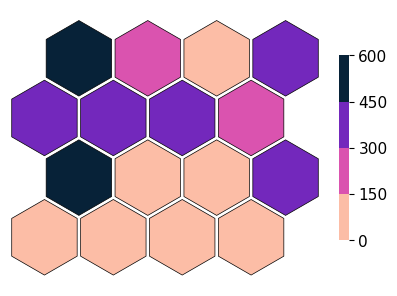

In [8]:
## max len
max_len_per_cluster = spells.group_by(["value", "spell"]).len().group_by("value").agg(pl.col("len").max())
max_len_per_cluster = pl.Series("value", np.arange(net_summer.n_nodes)).to_frame().join(max_len_per_cluster, how="left", on="value")
cmap = colormaps.bubblegum_r
net_summer.plot_on_map(max_len_per_cluster["len"].to_numpy(), cmap=cmap, linewidths=0.5, discretify=True, cbar_kwargs={"shrink": 0.6})

(<Figure size 500x400 with 2 Axes>, <Axes: >)

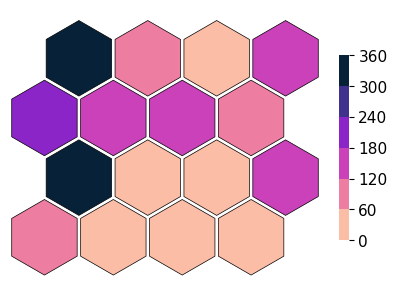

In [9]:
## max len
max_len_per_cluster = spells.group_by(["value", "spell"]).len().group_by("value").agg(pl.col("len").mean())
max_len_per_cluster = pl.Series("value", np.arange(net_summer.n_nodes)).to_frame().join(max_len_per_cluster, how="left", on="value")
cmap = colormaps.bubblegum_r
net_summer.plot_on_map(max_len_per_cluster["len"].to_numpy(), cmap=cmap, linewidths=0.5, discretify=True, cbar_kwargs={"shrink": 0.6})

In [10]:
labels_summer

<xarray.DataArray 'labels' (megatime: 191593)> Size: 2MB
array([15, 15, 15, ..., 15, 11, 12])
Coordinates:
  * megatime  (megatime) object 2MB MultiIndex
  * member    (megatime) <U12 9MB 'r10i1181p1f1' ... 'r9i1301p1f1'
  * time      (megatime) datetime64[ns] 2MB 1970-06-26T12:00:00 ... 2009-10-0...

# real space composites

In [16]:
get_region(dh.da)

(-80.0, 40.0, 15.549737930297852, 79.63350677490234)

In [23]:
da_tp = xr.open_zarr("/storage/workspaces/giub_meteo_impacts/ci01/CESM2/PRECL/past.zarr")["PRECL"]


In [ ]:
da_tp = xr.open_zarr("/storage/workspaces/giub_meteo_impacts/ci01/CESM2/PRECL/past.zarr")["PRECL"]

clim = da_tp.groupby("time.dayofyear").mean()
clim = smooth(clim, {'dayofyear': ('win', 15)})
clim = compute(clim, progress_flag=True)

In [20]:
da_tp = xr.open_zarr("/storage/workspaces/giub_meteo_impacts/ci01/CESM2/PRECL/past.zarr")["PRECL"]
da_tp = extract(da_tp, "all", None, -15, 40, 30, 75)
spells_reduced = spells.filter(pl.col("time").is_in(pl.Series(None, da_tp.time.values)))
mask_reduced = mask.sel(megatime=np.isin(mask.time.dt.year.values, da_tp.time.dt.year.values))
summer_reduced = summer.filter(pl.col("summer").dt.year().is_in(np.unique(da_tp.time.dt.year.values)))
index_reduced = summer_reduced.to_pandas().set_index(["member", "summer"]).index
da_tp = da_tp.stack({"megatime": ["member", "time"]}).sel(megatime=index_reduced).transpose("megatime", ...)
da_tp = compute(da_tp, progress_flag=True)

[########################################] | 100% Completed | 20.38 s


100%|██████████| 16/16 [00:00<00:00, 19.15it/s]


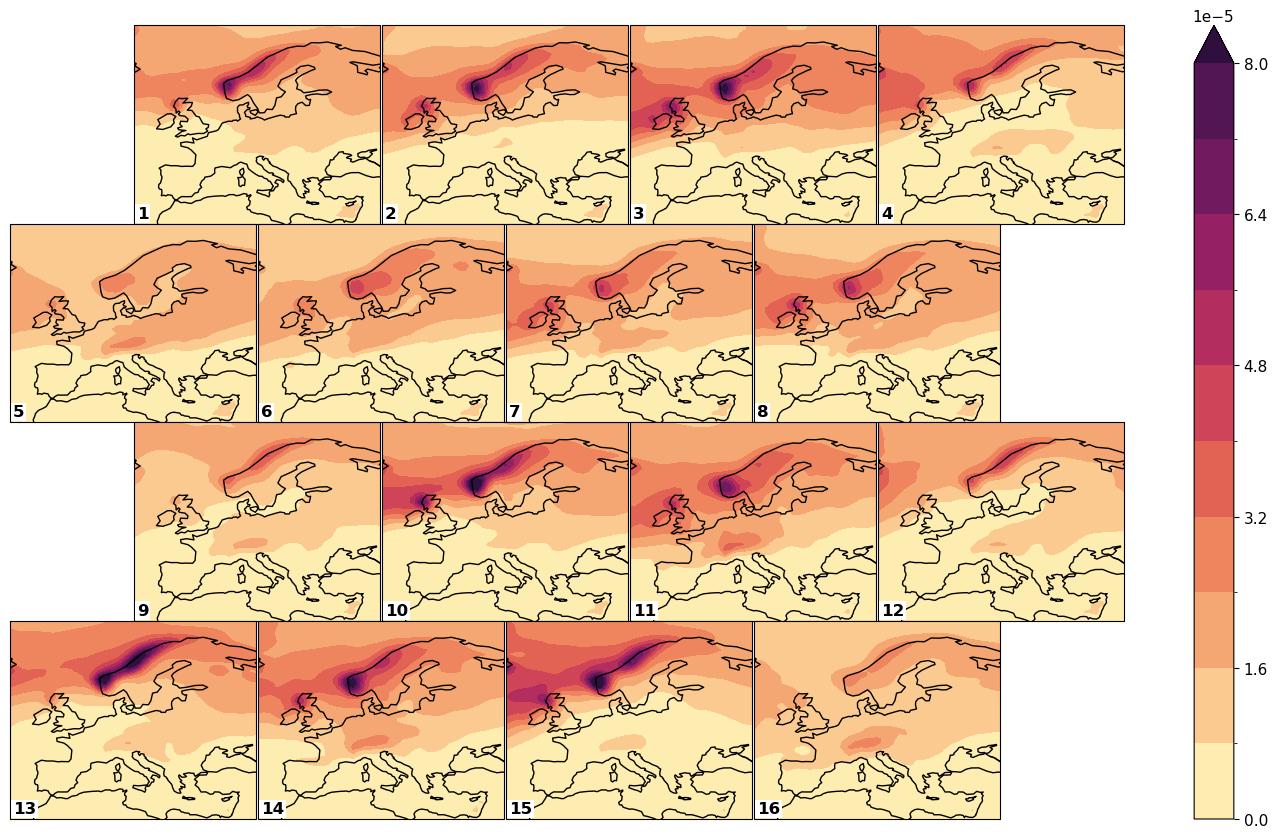

In [21]:
clu = Clusterplot(4, 4, honeycomb=True, region=get_region(da_tp), numbering=True)
_ = clu.add_any_contour_from_mask(da_tp * 1000, mask_reduced, cmap=colormaps.matter, levels=12, q=1-1e-3)
axes = clu.axes.ravel()
# for i in range(net.n_nodes):
#     jets = all_jets_center_summer.filter(pl.col("cluster") == i)
#     for j, jet in jets.group_by("jet ID", maintain_order=True):
#         lo, la, is_p = jet[["lon", "lat", "is_polar"]].to_numpy().T
#         axes[i].scatter(lo, la, c=is_p, lw=1, s=10, cmap=PINKPURPLE, vmin=0, vmax=1)